# Machine Learning Project 1

## Regression analysis and resampling methods


### Import packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from numpy.random import random, seed
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import display
from scipy.stats import norm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression

### Define Franke function

In [2]:
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

### Test drawing of the Franke function

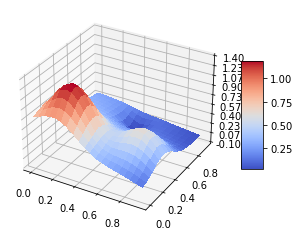

In [3]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)

z = FrankeFunction(x, y)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [4]:
def create_X(x, y, n=1 ):
    '''from x, y meshgrid vectors computes the design matrix for a polynomial model of degree n.'''
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    X = np.ones((N,l))

    
    for i in range(1,n+1):
        #starting from the index after the i-1 degree
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            #combinations of powers of x and y, starting from x**i
            X[:,q+k] = (x**(i-k))*(y**k)
            
    # The design matrix is set up as 1,x,y,x**2,x*y,y**2
    return X


## Part a)

### Set up data

- This is the data that we will use for all the program

In [5]:
#number of points for each axis
n_points = 50

#set random seed
np.random.seed(1234)
x0 = np.random.rand(n_points)

#set random seed
np.random.seed(4352)
y0 = np.random.rand(n_points)

#mesh arrays of x and y
x,y = np.meshgrid(x0,y0)

#create a dummy design matrix for the arrays of x and y
X0 = create_X(x,y)

#generate normal distributed noise 
noise_amp = 0.7
noise = noise_amp*np.random.randn(X0.shape[0])

#calculate starting target values with noise
z = FrankeFunction(X0[:,1],X0[:,2]) + noise


# The degree of the polynomial and the corresponding design matrix will be specific of each problem


### Scaling the design matrix

_This rescales the features of the design matrix.
Should we do a comparison of with and without scaling?_

In [6]:
def MatrixScaler(X):
    for i in range(X.shape[1]):
        if np.std(X[:,i]) == 0:
            X[:,i] = (X[:,i]-np.mean(X[:,i]))
        else:
            X[:,i] = (X[:,i]-np.mean(X[:,i]))/np.std(X[:,i])
    return X#[:,1:]

def TargetScaler(z):
    if(np.std(z)!=0):
        mean = np.mean(z)
        std = np.std(z)
        aux = (z-mean)/std
    return aux, mean, std

### OLS regression 

In [7]:
def OLS(X_train, X_test, z_train, z_test):
    '''
    Fit the model with OLS regression using the train set and 
    returns the predicted values for both the train and the test set.
    '''
    
    #extract regression coefficients
    beta_ols = np.linalg.pinv(X_train.T@X_train)@(X_train.T)@z_train
    
    #predict train and test values
    z_train_tilde_ols = X_train@beta_ols
    z_test_tilde_ols = X_test@beta_ols
    
    return z_train_tilde_ols, z_test_tilde_ols

The MSE test for OLS and degree  5
0.5764360485341125
MSE with intercept column from SKL
0.5764360485317614


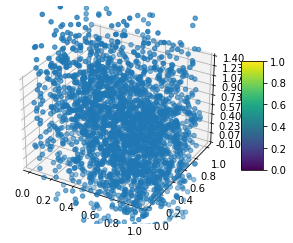

In [8]:
## THIS IS THE FIT CONSIDERING THE INTERCEPT (Intercept included in design matrix)


#degree of the polynomial
maxdegree = 5

#setup design matrix with polynomial model
X = create_X(x,y,maxdegree)


#split train and test set
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3,random_state=2)


# Intercept is included in the design matrix
skl = LinearRegression(fit_intercept=False).fit(X_train, z_train)

zpredictSKL = skl.predict(X_test)

#apply OLS regression
z_train_tilde_ols, z_test_tilde_ols = OLS(X_train, X_test, z_train, z_test)

#calculate train and test mse 
mse_train = mean_squared_error(z_train,z_train_tilde_ols)
mse_test = mean_squared_error(z_test,z_test_tilde_ols)

#calculate train and test r2
r2_train = r2_score(z_train,z_train_tilde_ols)
r2_test = r2_score(z_test,z_test_tilde_ols)

print("The MSE test for OLS and degree ",maxdegree)
print(mse_test)

print(f"MSE with intercept column from SKL")
print(mean_squared_error(z_test,zpredictSKL))
'''
print(mse_train)

print(r2_test)
print(r2_train)
'''


fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.scatter3D(X[:,1],X[:,2], z, cmap=cm.coolwarm)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [9]:
## THIS IS THE FIT WITHOUT THE INTERCEPT


#degree of the polynomial
maxdegree = 5

#setup design matrix with polynomial model
X = create_X(x,y,maxdegree)


#split train and test set
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3,random_state=2)


# Intercept is not included in the design matrix
skl = LinearRegression(fit_intercept=True).fit(X_train, z_train)

zpredictSKL = skl.predict(X_test)



# Use centered values for X and y when computing coefficients
z_offset = np.average(z_train, axis=0)
X_offset = np.average(X_train, axis=0)

#apply OLS regression
X_train_sc = X_train-X_offset
z_train_sc = z_train-z_offset

beta = np.linalg.pinv(X_train_sc.T@X_train_sc)@(X_train_sc.T)@z_train_sc


intercept = np.mean(z_offset - X_offset @ beta)

zpredictOwn = X_test @ beta

#calculate train and test mse 

mse_train = mean_squared_error(z_train,z_train_tilde_ols)
mse_test = mean_squared_error(z_test,zpredictOwn+intercept)

#calculate train and test r2
r2_train = r2_score(z_train,z_train_tilde_ols)
r2_test = r2_score(z_test,z_test_tilde_ols)

print("The MSE test for OLS and degree ",maxdegree)
print(mse_test)

print(f"MSE with intercept column from SKL")
print(mean_squared_error(z_test,zpredictSKL))

The MSE test for OLS and degree  5
0.5764360485319435
MSE with intercept column from SKL
0.5764360485317711


## Part b)

### Analysis of MSE as a function of complexity

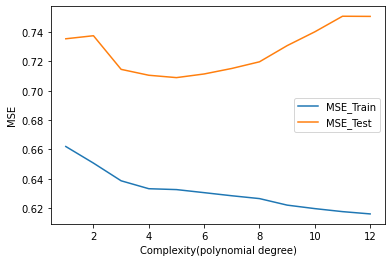

In [10]:

#maximum degree of polynomial
maxdegree = 12


#create arrays for results
polydegree = np.zeros(maxdegree)
MSE_OLS = np.zeros((maxdegree,2))



#cycle on polynomial degrees

for degree in range(maxdegree):
    
    X = create_X(x,y,degree+1)
    
    X = MatrixScaler(X)
    
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)

    z_t = z_test.reshape(len(z_test),1)
    polydegree[degree] = degree+1
    
    z_train_tilde_ols , z_test_tilde_ols = OLS(X_train, X_test, z_train, z_test) 
    
    MSE_OLS[degree, 0] = mean_squared_error(z_train,z_train_tilde_ols)
    MSE_OLS[degree, 1] = mean_squared_error(z_test,z_test_tilde_ols)  
    

#plot the results
plt.plot(polydegree,MSE_OLS[:,0],label='MSE_Train')
plt.plot(polydegree,MSE_OLS[:,1],label='MSE_Test')
plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('MSE')
plt.legend()
plt.show()

### Bootstrap method

In [11]:
#Important to split the data set before shuffling 
def bootstrap_OLS(X_train, X_test, z_train, z_test, n_bootstrap): 
    MSE = np.zeros((n_bootstrap,2))
    n = len(z_train)
    z_tilde_train_ols = np.empty((len(z_train), n_bootstrap))
    z_tilde_test_ols = np.empty((len(z_test), n_bootstrap))
    for i in range(n_bootstrap):
        sequence = np.random.randint(0,n,n)
        X1_train = X_train[sequence]
        z1_train = z_train[sequence]  
        z_tilde_train_ols[:,i] , z_tilde_test_ols[:,i] = OLS(X1_train, X_test, z1_train, z_test) 
        MSE[i,0] = mean_squared_error(z1_train,z_tilde_train_ols[:,i]) 
        MSE[i,1] = mean_squared_error(z_test,z_tilde_test_ols[:,i])  
    return z_tilde_train_ols, z_tilde_test_ols, MSE
# From now on, index 0 corresponds to train and 1 to test

### Check of central limit theorem

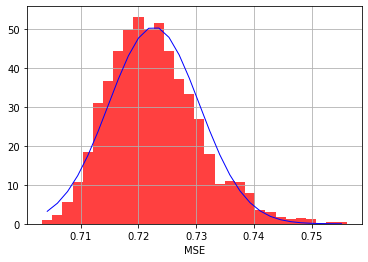

In [12]:
#number of resamplings
n_bootstrap = 3000


deg = 5
X = create_X(x,y,deg)
X = MatrixScaler(X)
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3)

#calculation of mse over the resamplings
_, _, mse_bs = bootstrap_OLS(X_train, X_test, z_train, z_test, n_bootstrap)
mse_bs_test = mse_bs[:,1]

n, binsboot, patches = plt.hist(mse_bs_test, density=True, bins=30, facecolor='red', alpha=0.75)

# Why does density = True show thousands in the height of the bins?
# shouldn't it be normalized ?

#add a 'best fit' line   

bincenters = np.mean(np.vstack([binsboot[0:-1],binsboot[1:]]), axis=0)

Norm = norm.pdf(bincenters, np.mean(mse_bs_test), np.std(mse_bs_test))
lt = plt.plot(bincenters, Norm, 'b', linewidth=1)

plt.xlabel('MSE')
plt.ylabel('')
plt.grid(True)
plt.show()

### Bias-variance tradeoff with bootstrap method

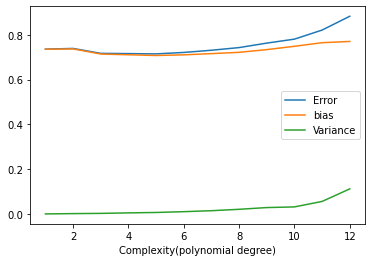

In [13]:
#maximum degree of polynomial
maxdegree = 12

#number of bootstrap resamplings
n_bs = 50


#create arrays for results
error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)
MSE_boot = np.zeros((maxdegree,2))



#cycle on polynomial degrees

for degree in range(maxdegree):
    
    X = create_X(x,y,degree + 1)
    
    X = MatrixScaler(X)
    
    # Why needed random_state
    # The random_seed makes sure we take the same indices for spliting every time, and it is necessary to test the same test set
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)

    _, z_pred, mse = bootstrap_OLS(X_train, X_test, z_train, z_test, n_bs )
    z_t = z_test.reshape(len(z_test),1)
    polydegree[degree] = degree+1
    error[degree] = np.mean( np.mean((z_t - z_pred)**2, axis=1, keepdims=True) )
    bias[degree] = np.mean( (z_t - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance[degree] = np.mean( np.var(z_pred, axis=1, keepdims=True) )
    
    MSE_boot[degree, 0] = np.mean(mse[:,0]) 
    MSE_boot[degree, 1] = np.mean(mse[:,1])   
    

#plot the results
plt.plot(polydegree, error, label='Error')
plt.plot(polydegree, bias, label='bias')
plt.plot(polydegree, variance, label='Variance')
plt.xlabel('Complexity(polynomial degree)')

plt.legend()
plt.show()

### MSE analysis

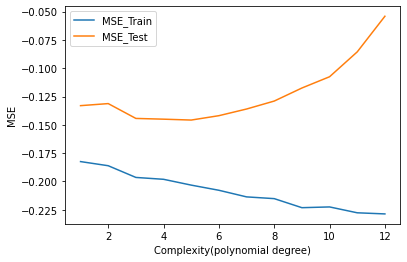

In [14]:
plt.figure()
plt.plot(polydegree,np.log10(MSE_boot[:,0]),label='MSE_Train')
plt.plot(polydegree,np.log10(MSE_boot[:,1]),label='MSE_Test')
plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('MSE')
plt.legend()
plt.show()

## Part c)

### Cross validation function

In [15]:
def cross_validation_OLS(k_folds, X,z):
    MSE = []
    kfold = KFold(n_splits = k_folds)
    for train_inds, test_inds in kfold.split(X):
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]

        z_train_tilde_ols , z_test_tilde_ols = OLS(X_train, X_test, z_train, z_test)

        MSE.append(mean_squared_error(z_test, z_test_tilde_ols))

    return (np.mean(MSE))

### Division in k-folds

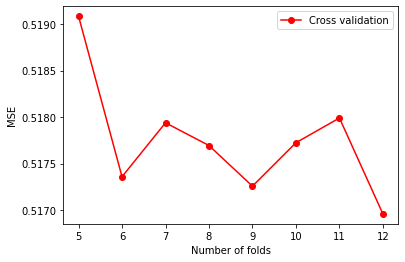

In [16]:
k_folds = range(5,13)
MSE_cross = np.zeros(len(k_folds))

maxdegree = 6
X = create_X(x,y,maxdegree)

for i in range(len(k_folds)):
    MSE_cross[i]=cross_validation_OLS(k_folds[i],X,z)

plt.figure()
plt.plot(k_folds,MSE_cross,"o-",c="r",label="Cross validation")
plt.xlabel('Number of folds')
plt.ylabel('MSE')
plt.legend()
plt.show()

### Comparison cross-validation and bootstrap

In [17]:


maxdegree = 10


MSE_test_boot = np.zeros(maxdegree)

k_folds = [5,10]

MSE_cross = np.zeros((maxdegree,2))

for degree in range(maxdegree):
    
    X = create_X(x,y,degree)
    X = MatrixScaler(X)
    
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
    z_train_tilde_ols , z_test_tilde_ols = OLS(X_train, X_test, z_train, z_test)
    
    _, z_pred, mse = bootstrap_OLS(X_train, X_test, z_train, z_test, n_bs )
    z_t = z_test.reshape(len(z_test),1)
    MSE_test_boot[degree] = np.mean(mse[:,1])
    for i  in range(len(k_folds)):
        k = k_folds[i]
        MSE_cross[degree,i] = cross_validation_OLS(k,X,z)


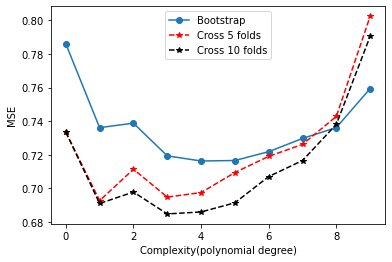

In [18]:
plt.figure()
plt.plot(range(maxdegree),MSE_test_boot,"o-",label = 'Bootstrap')
plt.plot(range(maxdegree),MSE_cross[:,0],"r*--", label ='Cross 5 folds' )
plt.plot(range(maxdegree),MSE_cross[:,1],"k*--", label = 'Cross 10 folds' )
plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('MSE')
plt.legend()
plt.show()

## Part d)

### Ridge regression function

_Do we have to remove the intercept ? 
In all other cases we have kept it._

In [19]:
def Ridge(X_train,X_test,z_train,z_test,lambd):

    # Since it relates to remove intercepts, better to use built in function in SKL
    RegRidge = linear_model.Ridge(lambd,fit_intercept= True)
    RegRidgeFalse = linear_model.Ridge(lambd,fit_intercept= False)
    #fit the model to the training data
    RegRidge.fit(X_train,z_train)
    RegRidgeFalse.fit(X_train,z_train)
    # and then make the prediction
    z_tilde_train = RegRidge.predict(X_train)
    z_tilde_test = RegRidge.predict(X_test)
    z_tilde_train_false = RegRidgeFalse.predict(X_train)
    z_tilde_test_false = RegRidgeFalse.predict(X_test)
    return z_tilde_train, z_tilde_test, z_tilde_train_false, z_tilde_test_false

### Fitting with Ridge regression over different $\lambda$

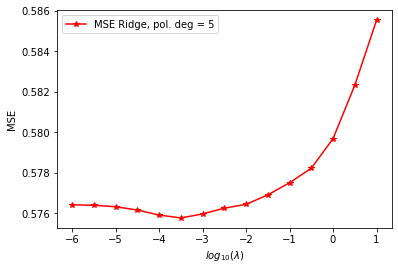

lambda to obtain miminum MSE: 0.00031622776601683794
0.5764242204374599
0.5764242199141612
0.576399632391937
0.5763996306861038
0.5763297883833665
0.5763297825453269
0.5761664484390875
0.5761664265081439
0.5759180263549891
0.5759179385350456
0.5757774545154568
0.5757771248020609
0.5759735271250055
0.5759723924053686
0.5762580951338515
0.5762542798553483
0.5764477789203658
0.5764353700732424
0.5769137333091457
0.5768782768527934
0.5775113945702626
0.5774202299823021
0.5782276332385202
0.5780041252721424
0.5796868083748246
0.579227350970415
0.5823188798232422
0.5816851140614971
0.5855215203177548
0.585504512424198


In [20]:

#degree of the polynomial
maxdegree = 5

#setup design matrix with polynomial model
X = create_X(x,y,maxdegree)



#X = MatrixScaler(X)

X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3,random_state=2)


#define interval of lambdas
nlambdas = 15
lambd = np.logspace(-6, 1, nlambdas)

MSE_test_Ridge = np.zeros(len(lambd))
MSE_test_RidgeFalse = np.zeros(len(lambd))
#
for i in range(len(lambd)):
    
    z_tilde_train, z_tilde_test, z_tilde_train_false, z_tilde_test_false = Ridge(X_train,X_test,z_train,z_test,lambd[i])
    
    MSE_test_Ridge[i] = mean_squared_error(z_test, z_tilde_test)
    MSE_test_RidgeFalse[i] = mean_squared_error(z_test, z_tilde_test_false)

plt.figure()
plt.plot(np.log10(lambd), MSE_test_Ridge, 'r*-', label = 'MSE Ridge, pol. deg = {}'.format(maxdegree))

plt.xlabel('$log_{10}(\lambda)$')
plt.ylabel('MSE')
plt.legend()
plt.show()
print('lambda to obtain miminum MSE:', lambd[np.argmin(MSE_test_Ridge)])
for i in range(len(lambd)):
    print(MSE_test_Ridge[i])
    print(MSE_test_RidgeFalse[i])

### Ridge regression with bootstrap

In [21]:
#Important to split the data set before shuffling 
def bootstrap_Ridge(X_train, X_test, z_train, z_test, n_bootstrap, lambd): 
    
    #prepare arrays for output
    MSE = np.zeros((n_bootstrap,2))
    z_tilde_train = np.zeros((len(z_train), n_bootstrap))
    z_tilde_test = np.zeros((len(z_test), n_bootstrap))
    
    n = len(z_train)
    
    #cycle on resamplings
    for i in range(n_bootstrap):
        
        #extract sequence for resampling
        sequence = np.random.randint(0,n,n)
        
        #resampled arrays
        X1_train = X_train[sequence]
        z1_train = z_train[sequence]
        
        #fit and predict
        z_tilde_train[:,i], z_tilde_test[:,i] = Ridge(X1_train, X_test, z1_train, z_test, lambd)
        
        #calculate mse on train and test
        MSE[i,0] = mean_squared_error(z1_train,z_tilde_train[:,i])
        MSE[i,1] = mean_squared_error(z_test,z_tilde_test[:,i])

    return z_tilde_train, z_tilde_test, MSE

Graphs do not agree for $\lambda\sim0$ because of different approach with intercept between OLS and Ridge ?

In [22]:


#select value of lambda
lambd = 10**-1


maxdegree = 6

n_bootstrap = 150

#prepare arrays for output

error_ols = np.zeros(maxdegree)
bias_ols = np.zeros(maxdegree)
variance_ols = np.zeros(maxdegree)

error_ridge = np.zeros(maxdegree)
bias_ridge = np.zeros(maxdegree)
variance_ridge = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)

MSE_boot_ridge = np.zeros((maxdegree,2))
MSE_boot_ols = np.zeros((maxdegree,2))


#cycle on degrees of polynomial
for degree in range(maxdegree):
    
    #create design matrix (starting from degree 1)
    X = create_X(x,y,degree+1)
    #rescale design matrix
    X = MatrixScaler(X)
    
    #train-test split
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
 
    #
    _, z_pred_ols, mse_ols = bootstrap_OLS(X_train, X_test,z_train, z_test, n_bootstrap)
    _, z_pred_ridge, mse_ridge = bootstrap_Ridge(X_train, X_test, z_train, z_test, n_bootstrap, lambd)
    
    #reshape test values
    z_t = z_test.reshape(len(z_test),1)
    polydegree[degree] = degree + 1
    
    #calculate error, bias, variance for Ridge regression
    error_ridge[degree] = np.mean( np.mean((z_t - z_pred_ridge)**2, axis=1, keepdims=True) )
    bias_ridge[degree] = np.mean( (z_t - np.mean(z_pred_ridge, axis=1, keepdims=True))**2 )
    variance_ridge[degree] = np.mean( np.var(z_pred_ridge, axis=1, keepdims=True) )
    
    #calculate error, bias, variance for OLS regression
    error_ols[degree] = np.mean( np.mean((z_t - z_pred_ols)**2, axis=1, keepdims=True) )
    bias_ols[degree] = np.mean( (z_t - np.mean(z_pred_ols, axis=1, keepdims=True))**2 )
    variance_ols[degree] = np.mean( np.var(z_pred_ols, axis=1, keepdims=True) )

    MSE_boot_ols[degree, 0] = np.mean(mse_ols[:,0]) 
    MSE_boot_ols[degree, 1] = np.mean(mse_ols[:,1]) 
    
    MSE_boot_ridge[degree, 0] = np.mean(mse_ridge[:,0]) 
    MSE_boot_ridge[degree, 1] = np.mean(mse_ridge[:,1])  
 
    
plt.plot(polydegree, error_ols, "--g" , label='Error OLS')
plt.plot(polydegree, bias_ols,"--b", label='Bias OLS')
plt.plot(polydegree, variance_ols, "--r", label='Variance OLS')

plt.plot(polydegree, error_ridge, "g", label='Error Ridge')
plt.plot(polydegree, bias_ridge, "b", label='Bias Ridge')
plt.plot(polydegree, variance_ridge, "r", label='Variance Ridge')

plt.xlabel('Complexity(polynomial degree)')

plt.yscale("log")

plt.legend()
plt.show()

ValueError: too many values to unpack (expected 2)

In [ ]:
plt.figure()
#plt.plot(polydegree,MSE_boot_ols[:,0],"r",label='MSE Train OLS')
#plt.plot(polydegree,MSE_boot_ols[:,1],"g",label='MSE Test OLS')

plt.plot(polydegree,MSE_boot_ridge[:,0],"r--",label='MSE Train Ridge')
plt.plot(polydegree,MSE_boot_ridge[:,1],"g--",label='MSE Test Ridge')

plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('MSE')

#plt.yscale("log")

plt.legend()
plt.show()

In [ ]:
nlambdas = 20
lambd = np.logspace(-4, 4, nlambdas)
max_degree = np.arange(1,10,1)
datapoints = 100
MSE_test_BRidge = np.zeros((len(lambd), len(max_degree)))
for degree in range(len(max_degree)):
    X = create_X(x,y,max_degree[degree])
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
    for i in range(len(lambd)):
        _,_,MSE_BRidge = bootstrap_Ridge(X_train, X_test,z_train, z_test, datapoints, lambd[i])
        MSE_test_BRidge[i,degree] = np.mean(MSE_BRidge[:,1]) # for test data set only

In [ ]:
plt.figure()
for degree in range(len(max_degree)):
    plt.plot(np.log10(lambd), MSE_test_BRidge[:,degree], 'o-', label='degree' + str(max_degree[degree]))
plt.legend()
#plt.legend(list(map(str, + (max_degree))) )
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')   
plt.show()

### Ridge regression with cross-validation 

In [ ]:
def cross_validation_Ridge(k_folds, X, z, lambd):
    MSE = []
    kfold = KFold(n_splits = k_folds)
    for train_inds, test_inds in kfold.split(X):
        X_train = X[train_inds]
        z_train = z[train_inds]

        X_test = X[test_inds]
        z_test = z[test_inds]

        _, z_tilde_test = Ridge( X_train, X_test, z_train, z_test, lambd)

        MSE.append(mean_squared_error(z_test,z_tilde_test))

    return (np.mean(MSE))

In [ ]:
lambd = 10
maxdegree = 12
n_bootstrap = 100



MSE_test_boot = np.zeros(maxdegree)
k_folds = [5,10]
MSE_cross = np.zeros((maxdegree,2))
poly_degree = np.zeros(maxdegree)
for degree in range(maxdegree):
    X = create_X(x,y,degree+1)
    poly_degree[degree] = degree + 1
    X = MatrixScaler(X)

    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
    
    _, _, mse = bootstrap_Ridge(X_train, X_test, z_train, z_test,n_bootstrap, lambd)

    MSE_test_boot[degree] = np.mean(mse[:,1])
    
    for i  in range(len(k_folds)):
        k = k_folds[i]
        MSE_cross[degree,i] = cross_validation_Ridge(k,X,z,lambd)




In [ ]:
plt.figure()
plt.plot(poly_degree,MSE_test_boot,"o-",label = 'Bootstrap')
plt.plot(poly_degree,MSE_cross[:,0],"r.-", label ='Cross 5 folds' )
plt.plot(poly_degree,MSE_cross[:,1],"ko-", label = 'Cross 10 fold' )
plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [ ]:
degree = 5
X = create_X(x,y,degree)
nlambdas = 20
lambd = np.logspace(-4, 4, nlambdas)
k_folds = np.arange(5,25,5)
datapoints = 100
MSE_test_CRidge = np.zeros((len(lambd), len(k_folds)))
for k in range(len(k_folds)):
    for i in range(len(lambd)):
        MSE_CRidge = cross_validation_Ridge(k_folds[k],X,z, lambd[i])
        MSE_test_CRidge[i,k] = MSE_CRidge # for test data set only

In [ ]:
plt.figure()
for k in range(len(k_folds)):
    plt.plot(np.log10(lambd), MSE_test_CRidge[:,k], '.--', label= str(k_folds[k]) + ' folds')
plt.legend()
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')  

## Part e)

### Loading the Boston Housing dataset

In [23]:
boston_data = load_boston()
boston_df = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)
boston_df['MEDV'] = boston_data.target

In [24]:
features = boston_df.columns.tolist() 
print(features[:-1])

['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


### Fitting a simple model with OLS and find appropriate degree of polynomial

All features are included in the model here

In [25]:
boston_df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


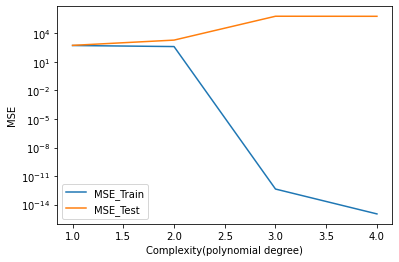

In [26]:
#degree of the polynomial model
maxdegree = 4

#target feature
z = boston_df['MEDV']
x = boston_df[features[:-1]] # original features

polydegree = np.zeros(maxdegree)
MSE_OLS = np.zeros((maxdegree,2))

for degree in range(maxdegree):
    
    #set up the model
    poly = PolynomialFeatures(degree+1)
    
    X = poly.fit_transform(x)
    
    X = MatrixScaler(X)
    
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
    
    #z_t = z_test.reshape(len(z_test),1)
    polydegree[degree] = degree+1
    
    z_train_tilde_ols , z_test_tilde_ols = OLS(X_train, X_test, z_train, z_test) 
    
    MSE_OLS[degree, 0] = mean_squared_error(z_train,z_train_tilde_ols)
    MSE_OLS[degree, 1] = mean_squared_error(z_test,z_test_tilde_ols)  

#plot the results
plt.plot(polydegree,MSE_OLS[:,0],label='MSE_Train')
plt.plot(polydegree,MSE_OLS[:,1],label='MSE_Test')
plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('MSE')
plt.yscale("log")
plt.legend()
plt.show()


### Feature selection given the correlation matrix

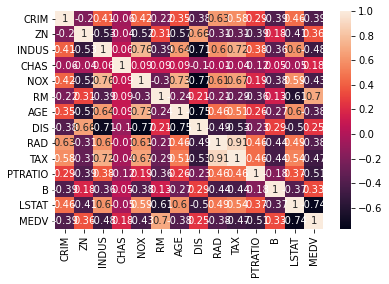

In [27]:
#print the correlation matrix
corr_matrix = boston_df.corr().round(2)
#sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(data=corr_matrix, annot=True)
array_corr = corr_matrix["MEDV"].abs()

In [28]:
def drop_columns(thres_corr):
    ''' Function takes in a value of thresholding and return the filtered dataframe, excluding already the target columns'''
    thresh_index = np.where((array_corr> thres_corr) == False)
    col_indi = np.append(thresh_index[0],13) # add target column
    filtered_boston = boston_df.drop(boston_df.columns[col_indi], axis=1)  
    return filtered_boston

In [29]:
filtered_boston = drop_columns(0.3)
filtered_boston

,CRIM,ZN,INDUS,NOX,RM,AGE,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.538,6.575,65.2,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.469,6.421,78.9,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.469,7.185,61.1,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.458,6.998,45.8,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.458,7.147,54.2,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.573,6.593,69.1,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.573,6.120,76.7,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.573,6.976,91.0,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.573,6.794,89.3,1.0,273.0,21.0,393.45,6.48


Now the features in the model are only the most correlated with the target feature

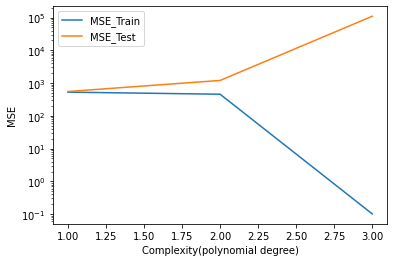

In [30]:
maxdegree = 3

z = boston_df['MEDV']

polydegree = np.zeros(maxdegree)
MSE_OLS = np.zeros((maxdegree,2))

for degree in range(maxdegree):
    
    poly = PolynomialFeatures(degree+1)
    
    X = poly.fit_transform(filtered_boston)
    
    X = MatrixScaler(X)
    
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
    
    #z_t = z_test.reshape(len(z_test),1)
    polydegree[degree] = degree+1
    
    z_train_tilde_ols , z_test_tilde_ols = OLS(X_train, X_test, z_train, z_test) 
    
    MSE_OLS[degree, 0] = mean_squared_error(z_train,z_train_tilde_ols)
    MSE_OLS[degree, 1] = mean_squared_error(z_test,z_test_tilde_ols)  

#plot the results
plt.plot(polydegree,MSE_OLS[:,0],label='MSE_Train')
plt.plot(polydegree,MSE_OLS[:,1],label='MSE_Test')
plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('MSE')
plt.yscale("log")
plt.legend()
plt.show()


### Compare the effect of different values of correlation threshold

In [31]:
# can not remove all the columns, then need an upper limint
max_corr = np.max(array_corr*(array_corr < 1))
print('Upper thresholding of correlation is: ', max_corr)
min_corr = np.min(array_corr*(array_corr > 0))
print('Lower thresholding of correlation is: ', min_corr)

Upper thresholding of correlation is:  0.74
Lower thresholding of correlation is:  0.18


In [32]:
degree = 3

z = boston_df['MEDV']

thresh = np.arange(min_corr, max_corr, 0.1)

MSE_OLS = np.zeros((len(thresh),2))
poly = PolynomialFeatures(degree)
for i in range(len(thresh)):
    
    filtered_boston = drop_columns(thresh[i])
    
    X = poly.fit_transform(filtered_boston)
    
    X = MatrixScaler(X)

    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
    
    z_train_tilde_ols , z_test_tilde_ols = OLS(X_train, X_test, z_train, z_test) 
    
    MSE_OLS[i, 0] = mean_squared_error(z_train,z_train_tilde_ols)
    MSE_OLS[i, 1] = mean_squared_error(z_test,z_test_tilde_ols)  



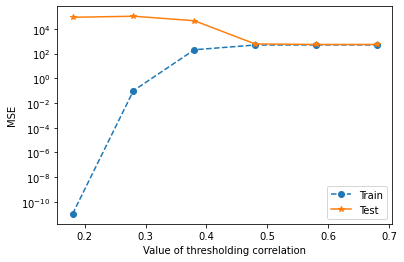

In [33]:
#plot the results

plt.plot(thresh, MSE_OLS[:,0],'o--', label='Train')
plt.plot(thresh,MSE_OLS[:,1], '*-', label='Test')

plt.xlabel('Value of thresholding correlation')
plt.ylabel('MSE')
plt.yscale("log")
plt.legend(loc = 'lower right')
plt.show()

In [34]:
max_degree = 3
degree = 3

z = boston_df['MEDV']

thresh = np.arange(0.2, max_corr, 0.1)
MSE_OLS = np.zeros((len(thresh),2))
polydegree = np.zeros(maxdegree)
MSE_OLS = np.zeros((maxdegree,len(thresh),2))

for degree in range(maxdegree):
    
    poly = PolynomialFeatures(degree+1)
    for i in range(len(thresh)):

        filtered_boston = drop_columns(thresh[i])

        X = poly.fit_transform(filtered_boston)

        X = MatrixScaler(X)

        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)

        z_train_tilde_ols , z_test_tilde_ols = OLS(X_train, X_test, z_train, z_test) 

        MSE_OLS[degree,i, 0] = mean_squared_error(z_train,z_train_tilde_ols)
        MSE_OLS[degree,i, 1] = mean_squared_error(z_test,z_test_tilde_ols)  


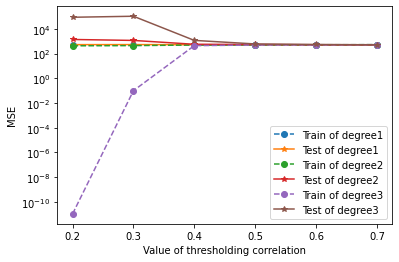

In [35]:
for degree in range(maxdegree):
    plt.plot(thresh, MSE_OLS[degree,:,0],'o--', label='Train of degree' + str(degree + 1))
    plt.plot(thresh,MSE_OLS[degree,:,1], '*-', label='Test of degree' + str(degree + 1))

plt.xlabel('Value of thresholding correlation')
plt.ylabel('MSE')
plt.yscale("log")
plt.legend(loc = 'lower right')
plt.show()
    

In [36]:
degree = 2
filtered_boston = drop_columns(0.4)
poly = PolynomialFeatures(degree+1)
    
X = poly.fit_transform(filtered_boston)
    
X = MatrixScaler(X)
    
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3)

#define interval of lambdas
nlambdas = 50
lambd = np.logspace(-4, 4, nlambdas)

MSE_test_Ridge = np.zeros(len(lambd))

#
for i in range(len(lambd)):
    _,z_tilde_test = Ridge(X_train, X_test, z_train, z_test, lambd[i],)
    MSE_test_Ridge[i] = mean_squared_error(z_test, z_tilde_test)
    

plt.figure()
plt.plot(np.log10(lambd), MSE_test_Ridge, 'r*-', label = 'MSE Ridge, pol. deg = {}'.format(deg))

lambda_min = lambd[MSE_test_Ridge.argmin()]

plt.xlabel('$log_{10}(\lambda)$')
plt.ylabel('MSE')
plt.legend()
plt.show()

ValueError: too many values to unpack (expected 2)

In [ ]:
lambda_min

In [ ]:
maxdegree = 5

z = boston_df['MEDV']

polydegree = np.zeros(maxdegree)
MSE_ridge = np.zeros((maxdegree,2))
MSE_OLS = np.zeros((maxdegree,2))

for degree in range(maxdegree):
    
    poly = PolynomialFeatures(degree+1)
    
    X = poly.fit_transform(filtered_boston)
    
    X = MatrixScaler(X)
    
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
    
    #z_t = z_test.reshape(len(z_test),1)
    polydegree[degree] = degree+1
    
    z_pred_train, z_pred_test = Ridge( X_train, X_test, z_train, z_test, lambda_min) 
    
    MSE_ridge[degree,0] = mean_squared_error(z_train,z_pred_train)
    MSE_ridge[degree,1] = mean_squared_error(z_test,z_pred_test)
    
    z_train_tilde_ols , z_test_tilde_ols = OLS(X_train, X_test, z_train, z_test) 
    
    MSE_OLS[degree, 0] = mean_squared_error(z_train,z_train_tilde_ols)
    MSE_OLS[degree, 1] = mean_squared_error(z_test,z_test_tilde_ols)  

In [ ]:
#plot the results
plt.plot(polydegree,MSE_ridge[:,0],"--",label='MSE Train Ridge')
plt.plot(polydegree,MSE_ridge[:,1],"--",label='MSE Test Ridge')
plt.plot(polydegree,MSE_OLS[:,0],label='MSE Train OLS')
plt.plot(polydegree,MSE_OLS[:,1],label='MSE Test OLS')
plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('MSE')
plt.yscale("log")
plt.legend()
plt.show()

### Fitting a simple model with Ridge and find appropriate degree of polynomial

a) Working with all 13 original features

In [ ]:
#degree of the polynomial model
maxdegree = 3
nlambdas = 5
lambd = np.logspace(-2, 4, nlambdas)

#target feature
z = boston_df['MEDV']
x = boston_df[features[:-1]] # original features
x.head()

In [ ]:
polydegree = np.zeros(maxdegree)
MSE_Ridge_train = np.zeros((maxdegree,len(lambd)))
MSE_Ridge_test = np.zeros((maxdegree,len(lambd)))

for degree in range(maxdegree):
        poly = PolynomialFeatures(degree+1)
        X = poly.fit_transform(x)
        X = MatrixScaler(X)
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
        #z_t = z_test.reshape(len(z_test),1)
        polydegree[degree] = degree+1
        for i in range(len(lambd)):
            z_train_tilde_Ridge , z_test_tilde_Ridge = Ridge(X_train, X_test, z_train, z_test, lambd[i]) 
            MSE_Ridge_train[degree, i] = mean_squared_error(z_train,z_train_tilde_Ridge)
            MSE_Ridge_test[degree, i] = mean_squared_error(z_test,z_test_tilde_Ridge)  

In [ ]:
#plot the results
for i in range(maxdegree):
    plt.plot(np.log10(lambd),MSE_Ridge_train[i,:],'.--', label='Train'+ ' dgr'+ str(i))
    plt.plot(np.log10(lambd),MSE_Ridge_test[i,:], '.--', label='Test' + ' dgr '+ str(i))

plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('MSE')
plt.yscale("log")
plt.legend(loc = 'lower right')
plt.show()

b) Only high correlated features
there is just slightly change in the number of features to create the design matrix => but huge change in design matrix

In [ ]:
#degree of the polynomial model
filtered_boston = drop_columns(0.4)
maxdegree = 3
nlambdas = 5
lambd = np.logspace(-2, 4, nlambdas)

#target feature
z = boston_df['MEDV']
polydegree = np.zeros(maxdegree)
MSE_Ridge_train_ = np.zeros((maxdegree,len(lambd)))
MSE_Ridge_test_ = np.zeros((maxdegree,len(lambd)))

for degree in range(maxdegree):
        poly = PolynomialFeatures(degree+1)
        X = poly.fit_transform(filtered_boston) # i just changed this point
        X = MatrixScaler(X)
        X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.3, random_state = 2)
        #z_t = z_test.reshape(len(z_test),1)
        polydegree[degree] = degree+1
        for i in range(len(lambd)):
            z_train_tilde_Ridge , z_test_tilde_Ridge = Ridge( X_train, X_test, z_train, z_test, lambd[i]) 
            MSE_Ridge_train_[degree, i] = mean_squared_error(z_train,z_train_tilde_Ridge)
            MSE_Ridge_test_[degree, i] = mean_squared_error(z_test,z_test_tilde_Ridge)  


In [ ]:
#plot the results
for i in range(maxdegree):
    plt.plot(np.log10(lambd),MSE_Ridge_train_[i,:],'.--', label='MSE_Train'+ ' degree '+ str(i))
    plt.plot(np.log10(lambd),MSE_Ridge_test_[i,:], '.--', label='MSE_Test' + ' degree '+ str(i))

plt.xlabel('Complexity(polynomial degree)')
plt.ylabel('MSE')
plt.yscale("log")
plt.legend(loc = 'lower right')
plt.show()
